In [1]:
import os, random, math
import numpy as np
import torch, torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset, TensorDataset
from torchvision import transforms
from torchvision.datasets import CIFAR100
from torchvision.models import ResNet18_Weights

from transformers import AutoModelForSequenceClassification, AutoTokenizer
from datasets import load_dataset
from tqdm.auto import tqdm 
from concurrent.futures import ProcessPoolExecutor, as_completed

import matplotlib.pyplot as plt
from scipy.stats import ks_1samp, uniform

plt.rcParams.update({
    "font.size": 14,          
    "axes.titlesize": 16,     
    "axes.labelsize": 14,     
    "xtick.labelsize": 12,    
    "ytick.labelsize": 12,
    "legend.fontsize": 12,    
    "figure.titlesize": 18,   
})


from utils import * 
seed = 142
rng = np.random.default_rng(seed)
torch.manual_seed(seed)
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)


Device: cpu


## Training classifiers

In [2]:
def set_seed(seed=42):
    random.seed(seed); np.random.seed(seed)
    torch.manual_seed(seed); torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
set_seed(101)

# ----------------------------
# Data
# ----------------------------
CIFAR_MEAN = (0.5071, 0.4867, 0.4408)
CIFAR_STD  = (0.2675, 0.2565, 0.2761)

def build_cifar100_loaders(
    data_root="./datasets/cifar_data",
    batch_size=256,
    num_workers=0,
    aug=True,
    binary_classes=None,   # e.g. (3,4) to keep two classes & map to {0,1}
):
    train_tf = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(CIFAR_MEAN, CIFAR_STD),
    ]) if aug else transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(CIFAR_MEAN, CIFAR_STD),
    ])

    test_tf = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(CIFAR_MEAN, CIFAR_STD),
    ])

    # Optional label remap to binary
    if binary_classes is not None:
        a, b = binary_classes
        ttf = (lambda y, a=a, b=b: 0 if y == a else 1 if y == b else -1)
    else:
        ttf = None

    train_base = CIFAR100(root=data_root, train=True,  download=True,
                          transform=train_tf,  target_transform=ttf)
    val_base   = CIFAR100(root=data_root, train=False, download=True,
                          transform=test_tf,   target_transform=ttf)

    if binary_classes is not None:
        tgt_train = getattr(train_base, "targets", getattr(train_base, "labels", None))
        tgt_val   = getattr(val_base,   "targets", getattr(val_base,   "labels", None))
        keep_train = [i for i, y in enumerate(tgt_train) if y in (0,1)]
        keep_val   = [i for i, y in enumerate(tgt_val)   if y in (0,1)]
        train_set, val_set = Subset(train_base, keep_train), Subset(val_base, keep_val)
    else:
        train_set, val_set = train_base, val_base

    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True,
                              num_workers=num_workers, pin_memory=True)
    val_loader   = DataLoader(val_set,   batch_size=batch_size, shuffle=False,
                              num_workers=num_workers, pin_memory=True)
    return train_loader, val_loader


### pre-trained Resnet-18 classifier

In [3]:
# #--------strong resnet model------------------
# def get_cifar100_pretrained_model(device="cpu"):
#     import detectors
#     import timm
#     print("Loading pretrained ResNet18 model from timm and adapting for CIFAR-100...")
    
#     model = timm.create_model("resnet18_cifar100", pretrained=True, num_classes=100)
#     model.to(device)
#     model.eval()
#     return model
    
# # Example usage:
# device = "cuda" if torch.cuda.is_available() else "cpu"
# print(f"Using device: {device}")

# model = get_cifar100_pretrained_model(device)


### weak and strong CNN based classifier

In [4]:
class SmallCIFARNet(nn.Module):
    def __init__(self, num_classes=100, c1=16, c2=32, c3=64, use_bn=False, dropout_p=0.30):
        super().__init__()
        BN1 = nn.BatchNorm2d(c1) if use_bn else nn.Identity()
        BN2 = nn.BatchNorm2d(c2) if use_bn else nn.Identity()
        BN3 = nn.BatchNorm2d(c3) if use_bn else nn.Identity()
        self.features = nn.Sequential(
            nn.Conv2d(3, c1, 3, padding=1, bias=not use_bn), BN1, nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Conv2d(c1, c2, 3, padding=1, bias=not use_bn), BN2, nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Conv2d(c2, c3, 3, padding=1, bias=not use_bn), BN3, nn.ReLU(inplace=True),
        )
        self.head = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Dropout(dropout_p),
            nn.Linear(c3, num_classes)
        )
    def forward(self, x): return self.head(self.features(x))

# ----------------------------
# Train / Eval
# ----------------------------
@torch.no_grad()
def evaluate(model, loader, device=DEVICE):
    model.eval()
    total, correct = 0, 0
    for x, y in loader:
        x, y = x.to(device, non_blocking=True), y.to(device, non_blocking=True)
        logits = model(x)
        pred = logits.argmax(1)
        correct += (pred == y).sum().item()
        total += y.numel()
    return correct / max(1, total)

def train_model(
    epochs=5,
    lr=1e-3,
    weight_decay=5e-4,
    label_smoothing=0.0,
    batch_size=256,
    num_workers=0,
    binary_classes=None,
    aug=True,
    seed=101,
    device=DEVICE,
):
    set_seed(seed)
    num_classes = 2 if binary_classes is not None else 100
    train_loader, val_loader = build_cifar100_loaders(
        batch_size=batch_size, num_workers=num_workers, aug=aug, binary_classes=binary_classes
    )
    model = SmallCIFARNet(num_classes=num_classes).to(device)
    opt = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    loss_fn = nn.CrossEntropyLoss(label_smoothing=label_smoothing)
    scaler = torch.amp.GradScaler(enabled=(device=="cuda"))

    best_acc, best_state = -1.0, None
    history = []

    for ep in range(1, epochs+1):
        model.train()
        running = 0.0
        for x, y in tqdm(train_loader, desc=f"Epoch {ep}/{epochs}", leave=False):
            x, y = x.to(device, non_blocking=True), y.to(device, non_blocking=True)
            opt.zero_grad(set_to_none=True)
            with torch.cuda.amp.autocast(enabled=(device=="cuda")):
                logits = model(x)
                loss = loss_fn(logits, y)
            scaler.scale(loss).backward()
            scaler.step(opt)
            scaler.update()
            running += loss.item() * y.size(0)

        train_loss = running / len(train_loader.dataset)
        val_acc = evaluate(model, val_loader, device)
        history.append({"epoch": ep, "train_loss": train_loss, "val_acc": val_acc})
        print(f"ep={ep:02d} | train_loss={train_loss:.4f} | val_acc={val_acc:.4f}")

        if val_acc > best_acc:
            best_acc = val_acc
            best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}

    # Load best-in-memory before returning
    if best_state is not None:
        model.load_state_dict(best_state)
    model.eval()
    return model, best_acc


In [5]:
# ----------------------------
# Example: weak vs strong
# ----------------------------
# Weak model: fewer epochs
weak_model, weak_val = train_model(epochs=5, lr=1e-3, seed=1001)

# Strong model: more epochs
strong_model, strong_val = train_model(epochs=25, lr=1e-3, seed=1001)

print(f"Weak best val acc:   {weak_val:.4f}")
print(f"Strong best val acc: {strong_val:.4f}")


Files already downloaded and verified
Files already downloaded and verified


Epoch 1/5:   0%|          | 0/196 [00:00<?, ?it/s]

/var/folders/0q/1br6tq4j3td60p7x3c_np0xh0000gn/T/ipykernel_56404/3995619522.py:68: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=="cuda")):


ep=01 | train_loss=4.3823 | val_acc=0.0616


Epoch 2/5:   0%|          | 0/196 [00:00<?, ?it/s]

ep=02 | train_loss=4.1293 | val_acc=0.0839


Epoch 3/5:   0%|          | 0/196 [00:00<?, ?it/s]

ep=03 | train_loss=3.9826 | val_acc=0.1097


Epoch 4/5:   0%|          | 0/196 [00:00<?, ?it/s]

ep=04 | train_loss=3.8694 | val_acc=0.1217


Epoch 5/5:   0%|          | 0/196 [00:00<?, ?it/s]

ep=05 | train_loss=3.7938 | val_acc=0.1274
Files already downloaded and verified
Files already downloaded and verified


Epoch 1/25:   0%|          | 0/196 [00:00<?, ?it/s]

ep=01 | train_loss=4.3823 | val_acc=0.0616


Epoch 2/25:   0%|          | 0/196 [00:00<?, ?it/s]

ep=02 | train_loss=4.1293 | val_acc=0.0839


Epoch 3/25:   0%|          | 0/196 [00:00<?, ?it/s]

ep=03 | train_loss=3.9826 | val_acc=0.1097


Epoch 4/25:   0%|          | 0/196 [00:00<?, ?it/s]

ep=04 | train_loss=3.8694 | val_acc=0.1217


Epoch 5/25:   0%|          | 0/196 [00:00<?, ?it/s]

ep=05 | train_loss=3.7938 | val_acc=0.1274


Epoch 6/25:   0%|          | 0/196 [00:00<?, ?it/s]

ep=06 | train_loss=3.7408 | val_acc=0.1436


Epoch 7/25:   0%|          | 0/196 [00:00<?, ?it/s]

ep=07 | train_loss=3.6856 | val_acc=0.1527


Epoch 8/25:   0%|          | 0/196 [00:00<?, ?it/s]

ep=08 | train_loss=3.6475 | val_acc=0.1587


Epoch 9/25:   0%|          | 0/196 [00:00<?, ?it/s]

ep=09 | train_loss=3.6127 | val_acc=0.1628


Epoch 10/25:   0%|          | 0/196 [00:00<?, ?it/s]

ep=10 | train_loss=3.5801 | val_acc=0.1716


Epoch 11/25:   0%|          | 0/196 [00:00<?, ?it/s]

ep=11 | train_loss=3.5416 | val_acc=0.1825


Epoch 12/25:   0%|          | 0/196 [00:00<?, ?it/s]

ep=12 | train_loss=3.5148 | val_acc=0.1843


Epoch 13/25:   0%|          | 0/196 [00:00<?, ?it/s]

ep=13 | train_loss=3.4867 | val_acc=0.1913


Epoch 14/25:   0%|          | 0/196 [00:00<?, ?it/s]

ep=14 | train_loss=3.4583 | val_acc=0.1964


Epoch 15/25:   0%|          | 0/196 [00:00<?, ?it/s]

ep=15 | train_loss=3.4380 | val_acc=0.2068


Epoch 16/25:   0%|          | 0/196 [00:00<?, ?it/s]

ep=16 | train_loss=3.4082 | val_acc=0.2106


Epoch 17/25:   0%|          | 0/196 [00:00<?, ?it/s]

ep=17 | train_loss=3.3878 | val_acc=0.2153


Epoch 18/25:   0%|          | 0/196 [00:00<?, ?it/s]

ep=18 | train_loss=3.3679 | val_acc=0.2217


Epoch 19/25:   0%|          | 0/196 [00:00<?, ?it/s]

ep=19 | train_loss=3.3454 | val_acc=0.2194


Epoch 20/25:   0%|          | 0/196 [00:00<?, ?it/s]

ep=20 | train_loss=3.3289 | val_acc=0.2307


Epoch 21/25:   0%|          | 0/196 [00:00<?, ?it/s]

ep=21 | train_loss=3.3165 | val_acc=0.2301


Epoch 22/25:   0%|          | 0/196 [00:00<?, ?it/s]

ep=22 | train_loss=3.2945 | val_acc=0.2395


Epoch 23/25:   0%|          | 0/196 [00:00<?, ?it/s]

ep=23 | train_loss=3.2745 | val_acc=0.2423


Epoch 24/25:   0%|          | 0/196 [00:00<?, ?it/s]

ep=24 | train_loss=3.2555 | val_acc=0.2398


Epoch 25/25:   0%|          | 0/196 [00:00<?, ?it/s]

ep=25 | train_loss=3.2403 | val_acc=0.2477
Weak best val acc:   0.1274
Strong best val acc: 0.2477


## Helper functions

In [6]:
MEAN = [0.5071, 0.4867, 0.4408]
STD  = [0.2675, 0.2565, 0.2761]

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=MEAN, std=STD),
])

# For plotting around xi (denormalize just for visualization)
mean_t = torch.tensor(MEAN)[:, None, None]
std_t  = torch.tensor(STD)[:, None, None]
def denormalize(img_t):
    x = img_t * std_t + mean_t
    return torch.clamp(x, 0, 1)

def class_counts(dataset, cls):
    return sum(1 for _, y in dataset if y == cls)


In [7]:
### --data generation--
def generate_cifar100_sequence(n, xi, class_pre=3, class_post=4):
    train = CIFAR100(root="./datasets/cifar_data", train=True,  download=True, transform=transform)
    test  = CIFAR100(root="./datasets/cifar_data", train=False, download=True, transform=transform)

    # Collect indices per class
    pre_idx  = [i for i,(_,y) in enumerate(train) if y==class_pre] + \
               [i+len(train) for i,(_,y) in enumerate(test) if y==class_pre]
    post_idx = [i for i,(_,y) in enumerate(train) if y==class_post] + \
               [i+len(train) for i,(_,y) in enumerate(test) if y==class_post]

    rng.shuffle(pre_idx); rng.shuffle(post_idx)

    need_pre  = xi
    need_post = n - need_pre
    assert need_pre <= len(pre_idx) and need_post <= len(post_idx), "Not enough images for requested n/xi."

    # Build a combined dataset view for easy indexing
    full = torch.utils.data.ConcatDataset([train, test])

    seq_idx = pre_idx[:need_pre] + post_idx[:need_post]
    imgs = []
    for i in seq_idx:
        img, _ = full[i]
        imgs.append(img)

    labels = [class_pre]*need_pre + [class_post]*need_post
    return torch.stack(imgs), np.array(labels)


In [8]:
### ---print examples---
def show_examples_around_xi(x, labels, xi, savepath=None):
    idxs = [xi-2, xi-1, xi, xi+1, xi+2]
    idxs = [i for i in idxs if 0 <= i < len(x)]
    fig, ax = plt.subplots(1, len(idxs), figsize=(3*len(idxs), 3))
    if len(idxs)==1: ax = [ax]
    for k,i in enumerate(idxs):
        img = denormalize(x[i]).permute(1,2,0).numpy()
        ax[k].imshow(img); ax[k].set_title(f"t={i+1}\ncls={labels[i]}")
        ax[k].axis("off")
    plt.tight_layout()
    if savepath:
        os.makedirs(os.path.dirname(savepath), exist_ok=True)
        plt.savefig(savepath, bbox_inches="tight")
    plt.show()

## data generation

Files already downloaded and verified
Files already downloaded and verified
Sequence shape: torch.Size([1000, 3, 32, 32])


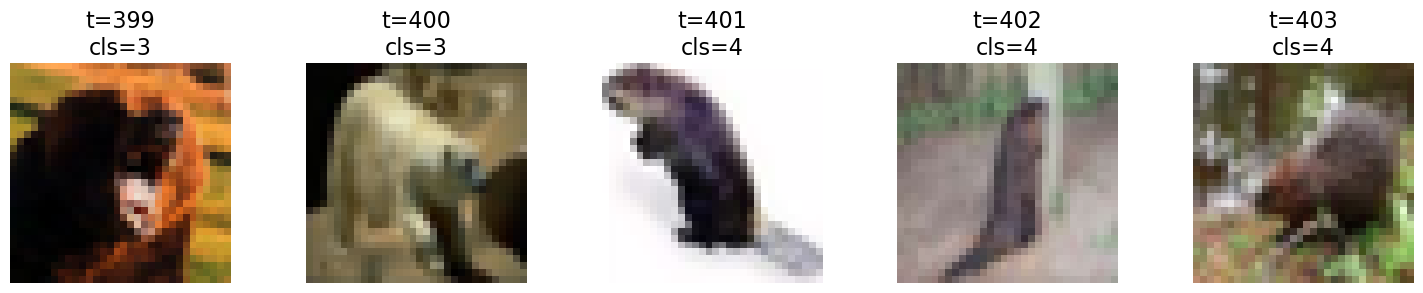

In [9]:
n      = 1000
xi     = 400              
cls_pre, cls_post = 3, 4 

data_cifar, label_cifar = generate_cifar100_sequence(n, xi, class_pre=cls_pre, class_post=cls_post)
print("Sequence shape:", data_cifar.shape)

show_examples_around_xi(data_cifar, label_cifar, xi, savepath="../images/cifar100-xi-panel.pdf")

In [10]:
@torch.no_grad()
def batched_predict(model, x, batch_size=200, device="cpu", T=1.0):
    model.eval()
    loader = DataLoader(TensorDataset(x), batch_size=batch_size, shuffle=False)
    probs_list, preds_list, logits_list = [], [], []
    for (xb,) in tqdm(loader, desc="Running model"):
        xb = xb.to(device, non_blocking=True)
        logits = model(xb)
        if T != 1.0:
            logits = logits / T
        probs = F.softmax(logits, dim=1)

        preds = probs.argmax(dim=1)
        logits_list.append(logits.detach().cpu())
        probs_list.append(probs.detach().cpu())
        preds_list.append(preds.detach().cpu())

    logits = torch.cat(logits_list, dim=0)  # (n, C)
    probs  = torch.cat(probs_list, dim=0)   # (n, C)
    preds  = torch.cat(preds_list, dim=0).numpy()  # (n,)

    return preds, probs, logits


## CONCH (new version)

In [11]:
# _, _, logits_resnet = batched_predict(model, data_cifar, device=device, T=1)
# p_values_conch_new = compute_conch_p_values(logits_resnet, class_before=3, class_after=4, nperm=800, random_state=seed)

In [12]:
_, _, logits_weak = batched_predict(weak_model, data_cifar, device=device, T=1)
p_values_conch_new_ver2 = compute_p_values(logits_weak, class_before=3, class_after=4, nperm=800, random_state=seed)

Running model:   0%|          | 0/5 [00:00<?, ?it/s]

computing CONCH p-values:   0%|          | 0/999 [00:00<?, ?it/s]

In [13]:
_, _, logits_strong = batched_predict(strong_model, data_cifar, device=device, T=1)
p_values_conch_new_ver3 = compute_p_values(logits_strong, class_before=3, class_after=4, nperm=800, random_state=seed)

Running model:   0%|          | 0/5 [00:00<?, ?it/s]

computing CONCH p-values:   0%|          | 0/999 [00:00<?, ?it/s]

## performance comparison

In [14]:
# print(confidence_set(p_values_conch_new, 0.05))
print(confidence_set(p_values_conch_new_ver2, 0.05))
print(confidence_set(p_values_conch_new_ver3, 0.05))

[393, 394, 395, 396, 397, 398, 399, 400, 401, 402, 403, 404, 405, 406, 409, 410, 411, 412, 413, 414, 415, 416, 417, 418, 419, 420, 421, 422, 423, 424, 425, 426, 427]
[398, 400, 401, 402, 403, 404, 405, 406, 408]


/var/folders/0q/1br6tq4j3td60p7x3c_np0xh0000gn/T/ipykernel_56404/599328259.py:60: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


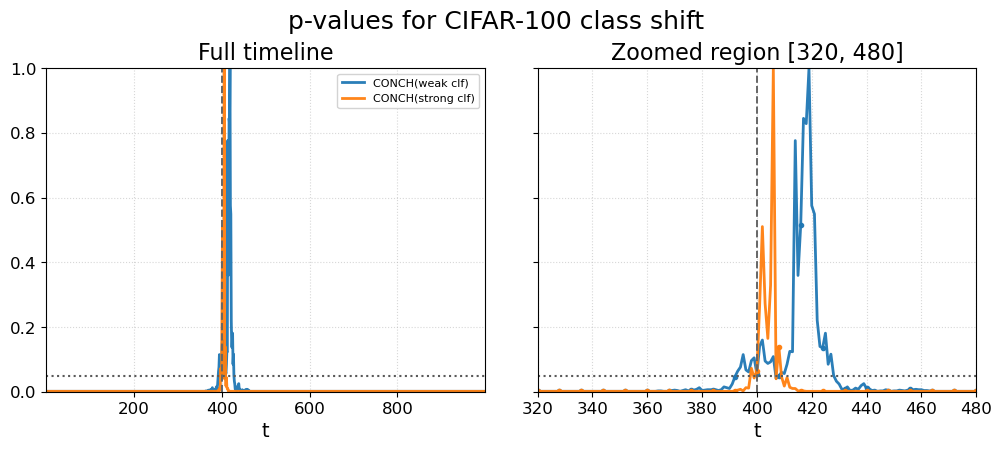

In [15]:
# inputs you already have:
series = [(p_values_conch_new_ver2, "CONCH(weak clf)"),
          (p_values_conch_new_ver3, "CONCH(strong clf)")]

COLORS = {
    "CONCH(weak clf)":   "C0",  # default blue
    "CONCH(strong clf)": "C1",  # default orange
}

thr_color, cp_color = "0.35", "0.40"      # neutral guides



alpha = 0.05
zoom_half_width = 80
title = "p-values for CIFAR-100 class shift"
outfile = "../images/CIFAR100-pvalues.pdf"

t = np.arange(1, n)
xi = int(xi)

# zoom window
z0 = max(1, xi - zoom_half_width)
z1 = min(n - 1, xi + zoom_half_width)
mask = (t >= z0) & (t <= z1)
mark_every = max(1, int(mask.sum()) // 20)

fig, (ax, axz) = plt.subplots(1, 2, figsize=(12, 4.2), sharey=True, gridspec_kw={"wspace": 0.12})

# left: full
for y, label in series:
    y = np.asarray(y)
    ax.plot(t, y, linewidth=2, label=label, color=COLORS[label], alpha=0.95)

ax.axhline(alpha, color=thr_color, linestyle=":", linewidth=1.5)
# ax.axvspan(z0, z1, alpha=0.08)
ax.axvline(xi, color=cp_color, linestyle="--", linewidth=1.4)
ax.set_xlim(1, n - 1); ax.set_ylim(0, 1)
ax.set_xlabel("t"); ax.set_title("Full timeline")
ax.grid(True, linestyle=":", alpha=0.5)
ax.legend(loc="upper right", fontsize=8, frameon=True, framealpha=0.85)

# right: zoom
for y, label in series:
    y = np.asarray(y)
    axz.plot(t[mask], y[mask], linewidth=2, marker="o",
             markevery=mark_every, markersize=3,
             label=label, color=COLORS[label], alpha=0.95)

axz.axhline(alpha, color=thr_color, linestyle=":", linewidth=1.5, label=f"Threshold (α={alpha})")
axz.axvline(xi, color=cp_color, linestyle="--", linewidth=1.4)
# axz.text(xi, 0.98, f"ξ={xi}", rotation=90, va="top", ha="center",
#          fontsize=8, transform=axz.get_xaxis_transform())
axz.set_xlim(z0, z1); axz.set_xlabel("t")
axz.set_title(f"Zoomed region [{z0}, {z1}]")
axz.grid(True, linestyle=":", alpha=0.5)
#axz.legend(loc="upper right", bbox_to_anchor=(1.02, 1.0), fontsize=8, frameon=True, framealpha=0.85)

fig.suptitle(title, y=1.02)
plt.tight_layout()
if outfile:
    plt.savefig(outfile, bbox_inches="tight", dpi=200)
plt.show()
